In [3]:
import pandas as pd
from datetime import timedelta 
import matplotlib.pyplot as plt
import seaborn as sns

## Initial dataset with some manipulations

In [4]:
df = pd.read_csv(r'C:\Users\sokin\Downloads\Assessment exercise dataset - orders.csv')

In [5]:
# manipulating date field
df['date_1'] = pd.to_datetime(df['order_timestamp']).dt.strftime('%Y-%m-%d %H:%M:%S')
df['date_2'] = pd.to_datetime(pd.to_datetime(df['date_1']).dt.strftime('%Y-%m-%d'))

In [6]:
# df['date_transform'] = pd.to_datetime(df['order_timestamp']).dt.strftime('%Y-%m-%d %H:%M:%S')

In [7]:
df

,order_id,user_id,order_timestamp,city,cuisine,paid_cash,amount,date_1,date_2
0,7322173742136,94223136441,2022-01-18 15:41:28 UTC,Αίγιο,Breakfast,True,3.6,2022-01-18 15:41:28,2022-01-18
1,7210978616924,204794985423,2022-01-02 17:50:50 UTC,Αγρίνιο,Breakfast,True,1.9,2022-01-02 17:50:50,2022-01-02
2,7221232906132,12703920390,2022-01-04 08:37:12 UTC,Αγρίνιο,Breakfast,True,1.7,2022-01-04 08:37:12,2022-01-04
3,7399605199800,673310109528,2022-01-31 11:33:05 UTC,Λιβαδειά,Breakfast,True,3.0,2022-01-31 11:33:05,2022-01-31
4,7264221279744,673310109528,2022-01-10 11:18:28 UTC,Λιβαδειά,Breakfast,True,3.0,2022-01-10 11:18:28,2022-01-10
...,...,...,...,...,...,...,...,...,...
534265,7383295241752,314285338626,2022-01-28 22:25:04 UTC,Αλεξανδρούπολη,Street food,True,11.9,2022-01-28 22:25:04,2022-01-28
534266,7383425578320,586121418057,2022-01-28 22:39:29 UTC,Αλεξανδρούπολη,Street food,True,9.9,2022-01-28 22:39:29,2022-01-28
534267,7364485291992,29082002418,2022-01-24 19:29:34 UTC,Αλεξανδρούπολη,Street food,True,15.1,2022-01-24 19:29:34,2022-01-24
534268,7231345759480,348528607896,2022-01-05 18:28:41 UTC,Αλεξανδρούπολη,Street food,True,14.7,2022-01-05 18:28:41,2022-01-05


In [8]:
# dataset with total orders per customer
df_orders=df.groupby('user_id', as_index=False)['order_id'].count()
df_orders=df_orders.rename({'order_id':'orders'}, axis=1)

## Data Process

In [9]:
data_process = df.groupby(['user_id']).agg({
        'date_2': lambda x: (pd.to_datetime(pd.Timestamp("today").strftime("%Y-%m-%d"))- x.max()).days,
        'order_id': 'count',
        'amount': 'sum'})

In [10]:
data_process.rename(columns={'date_2': 'Recency',
                         'order_id': 'Frequency',
                         'amount': 'MonetaryValue'}, inplace=True)

data_process.head()

,Recency,Frequency,MonetaryValue
user_id,,,
44118921,405,1,33.3
108938802,383,3,44.2
110361993,386,11,137.0
138437670,382,1,5.5
144777339,379,14,60.8


We have now calculated our values. But those aggregations are absolut and hard to explain as is. It is better to normalize our scores replacing those values with relative once with respect to the distribution

Pandas qcut splits numeric columns into quartiles.

For Recency and Frequency columns, the higher values (top quartile) are assigned with indicator 4 and lowest to 1. Higher values imply that customers have spent more money to our products or bought more often and the 1-4 score is assigned accordingly

The opposite logic is applied for recency as higher values mean that many days have passed since last purchase. Thus, customers with high values (top quartile) take score 1 and those with the smallest values 4

### Calculate R, F, M groups

In [14]:
# Calculate R and F groups
# Create labels for Recency and Frequency
r_labels = range(4, 0, -1)
f_labels = range(1, 5)
m_labels = range(1, 5)
# Assign these labels to 4 equal percentile groups 
r_groups = pd.qcut(data_process['Recency'], q=4, labels=r_labels)
# Assign these labels to 4 equal percentile groups 
# f_groups = pd.qcut(data_process['Frequency'], q=4, labels=f_labels)
f_groups= pd.cut(data_process['Frequency'].rank(pct=True), bins=4, labels=f_labels)
# Assign these labels to three equal percentile groups 
m_groups = pd.qcut(data_process['MonetaryValue'], q=4, labels=m_labels)
# Create new columns R,F and M 
data_process = data_process.assign(R = r_groups.values, F = f_groups.values,M = m_groups.values)
data_process.head()

Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.


,Recency,Frequency,MonetaryValue,R,F,M
user_id,,,,,,
44118921,405,1,33.3,1,1,3
108938802,383,3,44.2,3,2,3
110361993,386,11,137.0,3,4,4
138437670,382,1,5.5,3,1,1
144777339,379,14,60.8,4,4,4


In [15]:
rfm = data_process.copy()
rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis=1)
rfm['RFM_Score'].head()

user_id
44118921      5
108938802     8
110361993    11
138437670     5
144777339    12
Name: RFM_Score, dtype: int64

### Normalizing the rank of the customers

In [17]:
rfm['R_rank'] = rfm['Recency'].rank(ascending=False)
rfm['F_rank'] = rfm['Frequency'].rank(ascending=True)
rfm['M_rank'] = rfm['MonetaryValue'].rank(ascending=True)
 
# normalization
rfm['R_rank_norm'] = round((rfm['R_rank']/rfm['R_rank'].max())*100,2)
rfm['F_rank_norm'] = round((rfm['F_rank']/rfm['F_rank'].max())*100,2)
rfm['M_rank_norm'] = round((rfm['F_rank']/rfm['M_rank'].max())*100,2)
 
rfm.drop(columns=['R_rank', 'F_rank', 'M_rank'], inplace=True)

In [18]:
rfm

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Score,R_rank_norm,F_rank_norm,M_rank_norm
user_id,,,,,,,,,,
44118921,405,1,33.3,1,1,3,5,8.14,16.74,16.74
108938802,383,3,44.2,3,2,3,8,64.44,56.73,56.73
110361993,386,11,137.0,3,4,4,11,52.68,91.32,91.32
138437670,382,1,5.5,3,1,1,5,70.33,16.74,16.74
144777339,379,14,60.8,4,4,4,12,100.00,94.52,94.52
...,...,...,...,...,...,...,...,...,...,...
685557444369,379,1,6.8,4,1,1,6,100.00,16.74,16.74
685561325799,379,1,8.7,4,1,1,6,100.00,16.74,16.74
685561843323,379,1,7.2,4,1,1,6,100.00,16.74,16.74


### RFM Level

In [19]:
def rfm_scaling(df):
    if df['RFM_Score']==12:
        return '10.Champions'
    elif df['RFM_Score'] ==11 :
        return '9.Loyal Customers'
    elif df['RFM_Score'] ==10 :
        return '8.Potential Loyalists'
    elif df['RFM_Score'] ==9 :
        return '7.Hot'
    elif df['RFM_Score'] ==8 :
        return '6.Promising'
    elif df['RFM_Score'] ==7 :
        return '5.Need Attention'
    elif df['RFM_Score'] ==6 :
        return '4.Can\'t lose them'
    elif df['RFM_Score'] ==5 :
        return '3.About to sleep'
    elif df['RFM_Score'] ==4 :
        return '2.Hibernating'
    elif df['RFM_Score'] ==3 :
        return '1.Lost'
    else:
        return 'Newbies'
# Create a new variable RFM_Level
rfm['RFM_Level'] = rfm.apply(rfm_scaling, axis=1)
# Print the header with top 5 rows to the console
rfm.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Score,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Level
user_id,,,,,,,,,,,
44118921,405,1,33.3,1,1,3,5,8.14,16.74,16.74,3.About to sleep
108938802,383,3,44.2,3,2,3,8,64.44,56.73,56.73,6.Promising
110361993,386,11,137.0,3,4,4,11,52.68,91.32,91.32,9.Loyal Customers
138437670,382,1,5.5,3,1,1,5,70.33,16.74,16.74,3.About to sleep
144777339,379,14,60.8,4,4,4,12,100.00,94.52,94.52,10.Champions


In [20]:
# Some descriptive for higher RFMs
print('From:',round(100*len(rfm[(rfm['RFM_Level']=="10.Champions") | (rfm['RFM_Level']=="9.Loyal Customers")])/len(rfm),2),"%"," of our customers, we have:",round(100*rfm[(rfm['RFM_Level']=="10.Champions") | (rfm['RFM_Level']=="9.Loyal Customers")]['MonetaryValue'].sum()/rfm['MonetaryValue'].sum(),2),"% of our monetary revenues")
print('From:',round(100*len(rfm[(rfm['RFM_Level']=="10.Champions") | (rfm['RFM_Level']=="9.Loyal Customers")])/len(rfm),2),"%"," of our customers, we have:",round(100*rfm[(rfm['RFM_Level']=="10.Champions") | (rfm['RFM_Level']=="9.Loyal Customers")]['Frequency'].sum()/rfm['Frequency'].sum(),2),"% of our total orders")
print('Pareto principle is not working here!')
print('Champions & Loyal Customers have mean frequency:',round(rfm[(rfm['RFM_Level']=="10.Champions") | (rfm['RFM_Level']=="9.Loyal Customers")].Frequency.mean(),2), 'against the overall mean:',round(rfm.Frequency.mean(),2))
print('Champions & Loyal Customers have mean monetary value:',round(rfm[(rfm['RFM_Level']=="10.Champions") | (rfm['RFM_Level']=="9.Loyal Customers")].MonetaryValue.mean(),2), 'against the overall mean:',round(rfm.MonetaryValue.mean(),2))
print('Champions & Loyal Customers have mean recency days:',round(rfm[(rfm['RFM_Level']=="10.Champions") | (rfm['RFM_Level']=="9.Loyal Customers")].Recency.mean(),0), 'against the overall mean:',round(rfm.Recency.mean(),0))

From: 19.52 %  of our customers, we have: 50.11 % of our monetary revenues
From: 19.52 %  of our customers, we have: 54.52 % of our total orders
Pareto principle is not working here!
Champions & Loyal Customers have mean frequency: 12.23 against the overall mean: 4.38
Champions & Loyal Customers have mean monetary value: 95.83 against the overall mean: 37.34
Champions & Loyal Customers have mean recency days: 380.0 against the overall mean: 389.0


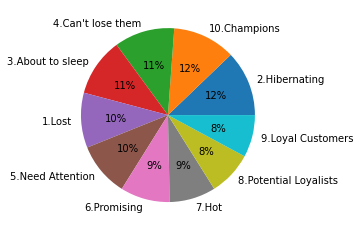

In [21]:
#a pie chart for the customers RFM distribution
plt.pie(rfm.RFM_Level.value_counts(),
        labels=rfm.RFM_Level.value_counts().index,
        autopct='%.0f%%')
plt.show()

## Export datasets for excel dashboard

In [ ]:
df_final = df.merge(rfm, how='inner', on='user_id')

In [ ]:
# df_final.to_excel("orders_rfm.xlsx")

In [ ]:
# rfm.to_excel("rfm.xlsx")